### 以下參考 https://www.itread01.com/content/1549244008.html
### 訓練過程說明可以參考 https://keras.io/api/applications/ 的 "Fine-tune InceptionV3 on a new set of classes"
### 我們只調整參數盡量優化結果

### import library、建立讀入資料的前處理generator(包括normalize、一些augmentation)：

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers import GlobalAveragePooling2D,Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adagrad
# 資料準備
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,# ((x/255)-0.5)*2  歸一化到±1之間
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

### 調整參數：

In [2]:
train_directory = './train'
validation_directory = './validation'


set_GAP_LAYER = 17 #第幾層之上全凍結，其之下全部解凍
epochs = 2
learning_rate = 0.0001 # 解凍後的learning rate
nums_of_label = 101 #output幾種類別
training_batch_size = 100 #一個training_batch的資料個數
validation_batch_size = 100 #一個validation_batch的資料個數

training_total_file_number = 80800 #總共training資料個數
validate_total_file_number = 10100 #總共validating資料個數

# https://www.codespeedy.com/how-to-set-steps-per-epoch-with-keras/
import math
def calculate_spe(y, batch_size):
    return int(math.ceil((1. * y) / batch_size)) 
steps_per_epoch = calculate_spe(training_total_file_number, training_batch_size)
validation_steps = calculate_spe(validate_total_file_number, validation_batch_size)

### 建立之後model.fit_generator要輸入的mapping資料(減少RAM占用)：

In [3]:
train_generator = train_datagen.flow_from_directory(directory=train_directory,
                                  target_size=(299,299),#Inception V3規定大小 299*299
                                  batch_size=training_batch_size,
                                  class_mode='categorical')
val_generator = val_datagen.flow_from_directory(directory=validation_directory,
                                target_size=(299,299),
                                batch_size=validation_batch_size,
                                class_mode='categorical')

Found 80800 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


### 沿用inception v3模型和訓練好的權重，並在其尾端接上自訂output layer：

In [4]:
# 構建基礎模型
base_model = InceptionV3(weights='imagenet',include_top=False)

# 增加新的輸出層
x = base_model.output
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D 將 MxNxC 的張量轉換成 1xC 張量，C是通道數
x = Dense(1024,activation='relu')(x)
predictions = Dense(nums_of_label,activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)

### 調整解凍範圍：

In [5]:
def setup_to_transfer_learning(model,base_model):#base_model
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

def setup_to_fine_tune(model,base_model):
    GAP_LAYER = set_GAP_LAYER
    for layer in base_model.layers[:GAP_LAYER+1]:
        layer.trainable = False
    for layer in base_model.layers[GAP_LAYER+1:]:
        layer.trainable = True
    model.compile(optimizer=Adagrad(lr=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])

### 訓練：

In [6]:
setup_to_transfer_learning(model,base_model)
history_tl = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=validation_steps)
model.save('./train_x_layers.h5')

setup_to_fine_tune(model,base_model)
history_ft = model.fit(train_generator,
                                 steps_per_epoch=steps_per_epoch,
                                 epochs=epochs,
                                 validation_data=val_generator,
                                 validation_steps=validation_steps)

Epoch 1/2
808/808 [==============================] - 1955s 2s/step - loss: 2.6815 - accuracy: 0.3611 - val_loss: 1.9177 - val_accuracy: 0.5102
Epoch 2/2
808/808 [==============================] - 1875s 2s/step - loss: 1.8048 - accuracy: 0.5338 - val_loss: 1.8119 - val_accuracy: 0.5459
Epoch 1/2
808/808 [==============================] - 1761s 2s/step - loss: 2.8168 - accuracy: 0.3390 - val_loss: 2.1538 - val_accuracy: 0.4811
Epoch 2/2
808/808 [==============================] - 1885s 2s/step - loss: 2.0142 - accuracy: 0.5031 - val_loss: 1.8963 - val_accuracy: 0.5264


### 繪製accuracy和loss對epoch折線圖：

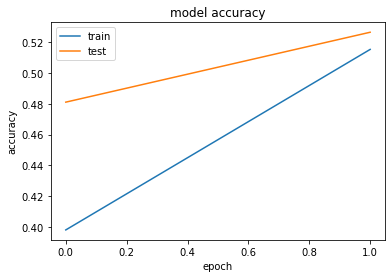

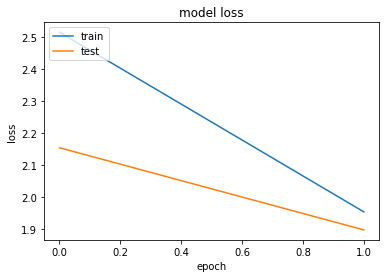

In [7]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') # 這裡的test其實是validation
plt.show()

# summarize history for loss
plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') # 這裡的test其實是validation
plt.show()

### 確認accuracy符合要求後，儲存模型：

In [8]:
model.save('./model.h5')